In [1]:
import os 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns

from src.data_exploration import *
from src.visualization import *

PATH_TO_SIGMORPHON20 = "data/SIGMORPHON2020/train"
PATH_TO_DECODE = "replication/sigmorphon_decode"

# SIGMORPHON Lemma Overlap vs. Performance

We begin by trying to investigate SIGMORPHON test performance as a function of lemma overlap between test & train, but we see that few languages have overlap of less than 100%.

In [49]:
# Get a dictionary mapping all languages to a set of lemmas seen during train
sigmorphon_dict = {}
for f in [f for f in os.listdir(PATH_TO_SIGMORPHON20) if "." not in f]:
     for lang in set([l.strip().split(".")[0] for l in os.listdir(f"{PATH_TO_SIGMORPHON20}/{f}")]):
        train, dev, _ = parse_files(f"{PATH_TO_SIGMORPHON20}/{f}/{lang}", 0)
        sigmorphon_dict[lang] = set(train + dev)

In [50]:
def get_overlap(family, lang, seen_lemmas):
    """Helper function to get the performance on seen & unseen lemmas for SIGMORPHON"""
    
    # Get the lemmas from the test file 
    lemmas = [l.strip().split("\t")[0] for l in open(f"{PATH_TO_SIGMORPHON20}/{family}/{lang}.tst").readlines()]
    
    # Get whether the model correctly predicted the corresponding inflected form 
    correct = [l.strip().split("\t")[-1] == "0" for l in open(f"{PATH_TO_DECODE}/{family.lower()}/{lang}..decode.tsv").readlines()[1:]]
    
    # Tally up the seen & unseen totals & numbers correct 
    seen_total = 0
    unseen_total = 0
    seen_correct = 0
    unseen_correct = 0
    for cor, lem in zip (correct, lemmas):
        if lem in seen_lemmas:
            seen_total += 1
            if cor:
                seen_correct += 1
        else:
            unseen_total += 1
            if cor:
                unseen_correct += 1
    return seen_total, unseen_total, seen_correct, unseen_correct

In [53]:
for family in ["Niger-Congo", "Uralic", "Romance"]:
    print(f"---------\n{family}\n---------")
    for lang in sorted(set([l.strip().split(".")[0] for l in os.listdir(f"{PATH_TO_DECODE}/{family.lower()}")])):
        seen_total, unseen_total, seen_correct, unseen_correct = get_overlap(family, lang, sigmorphon_dict[lang])
        print(f"{lang}:")
        print(f"\tPercent correct seen: {seen_correct / seen_total :.3f} (n = {seen_total})")
        print(f"\tPercent correct unseen: {(unseen_correct / unseen_total) if unseen_total > 0 else 0 :.3f} (n = {unseen_total})")
    print("\n\n")

---------
Niger-Congo
---------
aka:
	Percent correct seen: 1.000 (n = 763)
	Percent correct unseen: 0.000 (n = 0)
gaa:
	Percent correct seen: 0.994 (n = 169)
	Percent correct unseen: 0.000 (n = 0)
kon:
	Percent correct seen: 0.981 (n = 156)
	Percent correct unseen: 0.000 (n = 0)
lin:
	Percent correct seen: 1.000 (n = 46)
	Percent correct unseen: 0.000 (n = 0)
lug:
	Percent correct seen: 0.906 (n = 977)
	Percent correct unseen: 0.000 (n = 0)
nya:
	Percent correct seen: 1.000 (n = 853)
	Percent correct unseen: 0.000 (n = 0)
sna:
	Percent correct seen: 1.000 (n = 456)
	Percent correct unseen: 0.000 (n = 0)
sot:
	Percent correct seen: 0.980 (n = 99)
	Percent correct unseen: 0.000 (n = 0)
swa:
	Percent correct seen: 1.000 (n = 910)
	Percent correct unseen: 0.000 (n = 0)
zul:
	Percent correct seen: 0.923 (n = 78)
	Percent correct unseen: 0.000 (n = 0)



---------
Uralic
---------
est:
	Percent correct seen: 0.952 (n = 7637)
	Percent correct unseen: 0.000 (n = 0)
fin:
	Percent correct seen:

# Distribution of SIGMORPHON Lemma Overlap

Since we saw that a lot of the languages for which we had model results had 100% test overlap above, we can now investigate the overall distribution of lemma overlap in the SIGMORPHON data. 

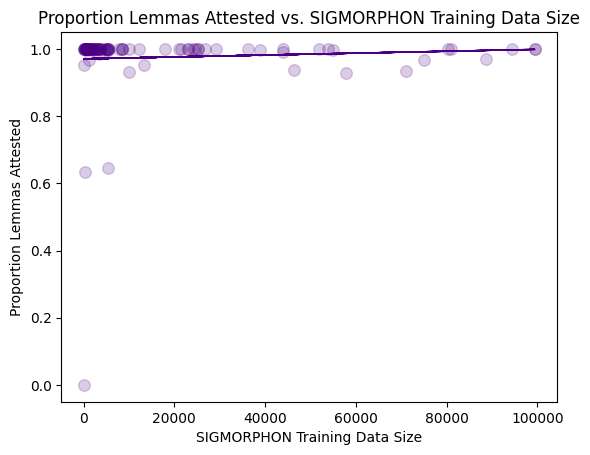

Pearson's R:	0.063,	 p = 0.5551919542101837
Spearman:	-0.293,	 p = 0.005065425203739157
Kendall's Tau:	-0.226,	 p = 0.005865440627355873


In [30]:
# Is there a relationship between lemma overlap and training size?
trn_sz, overlap, languages = run_correlation(PATH_TO_SIGMORPHON20, train_size, lemma_overlap)
plot_stats(trn_sz, 
           overlap, 
           "SIGMORPHON Training Data Size", 
           "Proportion Lemmas Attested")

In [18]:
# Let's figure out what the outliers are from the plot above
for lang, ovlp in zip(languages, overlap):
    if ovlp < 0.8:
        print(lang, ovlp)

Iranian/tgk 0.0
Tungusic/evn 0.6470588235294118
Uralic/lud 0.6341463414634146


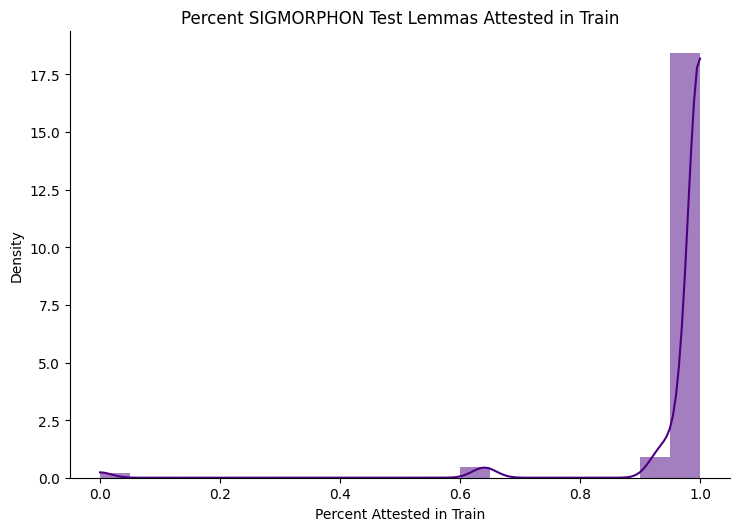

Mean: 0.975 (std: 0.11690906230028932)


In [31]:
# Density plot of the overlap values, and calculation of the mean and standard deviation
sns.displot(overlap,
             color="indigo",
             linewidth=0,
             alpha=0.5,
             kde=True,
             binwidth = 0.05,
             kde_kws = {"bw_adjust": 0.4},
             stat="density",
             aspect=1.5,
           )
plt.xlabel("Percent Attested in Train")
plt.title("Percent SIGMORPHON Test Lemmas Attested in Train")
plt.show()

overlap = np.asarray(overlap)
print(f"Mean: {np.mean(overlap) :.3f} (std: {np.std(overlap)})")